In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Install and import necessary libraries

In [ ]:
!pip install advertools
!pip install emot
!python -m spacy download uk_core_news_md
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 5.6 MB/s eta 0:00:00
2023-04-29 05:42:41.796409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perfo

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import advertools as adv
from collections import Counter
import emot
import spacy
from nltk.tokenize import TweetTokenizer
from collections import defaultdict
import numpy as np
from string import punctuation
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import stanza

# Dowload dataset

In [ ]:
data = pd.read_csv('/content/3795text_original_tag_cleaned.csv')
data = data.rename(columns={'TEXT':'text', 'IS_SARCASTIC': 'is_sarcastic', 'NO_TAGS':'no_tags', 'USERNAME':'username', 'DATE':'date'})

In [ ]:
data.head()

,is_sarcastic,text,no_tags,username,date
0,1,графіки виживання тритонів і піраміди смертнос...,графіки виживання тритонів і піраміди смертнос...,__freecafe__,2011-11-23 13:44:53+00:00
1,1,@lovemyself_not оні ти мене заблокуєш я люблю ...,@lovemyself_not оні ти мене заблокуєш я люблю ...,__k1t___,2023-02-08 16:47:21+00:00
2,1,@k1207h03 я броньована бля😎/сарк,@k1207h03 я броньована бля😎,__k1t___,2023-01-26 08:13:33+00:00
3,1,"мене не добавляють у різні списочки по типу ""г...","мене не добавляють у різні списочки по типу ""г...",__k1t___,2023-01-24 09:41:07+00:00
4,1,@sorixben можу стати 😇/сарк,@sorixben можу стати 😇,__k1t___,2023-01-21 07:49:32+00:00


In [ ]:
data[data['text'].duplicated() == True]

,is_sarcastic,text,no_tags,username,date


In [ ]:
data[data.duplicated() == True]

,is_sarcastic,text,no_tags,username,date


In [ ]:
print(data[data['is_sarcastic'] == True].shape)
print(data[data['is_sarcastic'] == False].shape)
print(data.shape)

(3795, 5)
(3795, 5)
(7590, 5)


# Do basic preprocessing

In [ ]:
with open('/content/stopwords_ua.txt', encoding='utf-8') as file:
    stops = file.read().split()
    stops = stops + ['twitter', 'instagram', 'http', 'https', 'com', 'vk', 'cc', 'youtube', 'facebook', 'шо', 'нє']

In [ ]:
tokenizer = TweetTokenizer()
# nlp = spacy.load("uk_core_news_md")

def normalize_elongated_words(text):
    """Performs normalization of words with elongated vowels. 
    For example, 'дуууже' -> 'дуже'.

  Args:
    text (str): text to be preprocessed

  Returns:
    str: text with normalized elongated words
  """

    regex = re.compile(r'(\w)\1+')
    normalized = []
    for token in tokenizer.tokenize(text):
      if regex.search(token):
        normalized.append(re.sub(r'(\w)\1+', r'\1', token))
      else:
        normalized.append(token)
    return ' '.join(normalized)

def basic_cleaning(text):
  """Performs basic text cleaning, specifically remove leading/trailing spaces,
     latin characters, punctuation, hashtags, links, user mentions, more than
     one space, numbers; normalizes elongated word, substitutes apostrophe
     with another similar symbol and finally lowercases text.

  Args:
    text (str): text to be preprocessed

  Returns:
    str: cleaned text
  """
  text = re.sub('[A-Za-z]+', '', text)
  text = re.sub('#\w+', '', text)
  text = re.sub('.pic.\S+', '', text)
  text = re.sub('http\S+', '', text)
  text = re.sub('bit.ly/\S+', '', text)
  text = text.strip('[link]') 
  text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) 
  text = text.lower() 
  text = re.sub('([0-9]+)', '', text)
  text = re.sub(r'[\\!"#$%&\(\)*+,-./:;<=>?\[\]^_`{|}~•@—–…¯\\ツ¯‼«»☺️„“™]+', '', text)
  text = re.sub('\s+', ' ', text) 
  text = re.sub('’', "'", text)
  text = normalize_elongated_words(text)
  text = text.strip()
  return text

In [ ]:
import stanza
stanza.download("uk", verbose=False)
uk_nlp = stanza.Pipeline('uk')

def perform_pos_tagging(text):
  """Performs part of speech tagging on given text.

  Args:
    text (str): text to be preprocessed

  Returns:
    str: part of speech tags separated by spaces
  """
  return [(word.text, word.pos) for sent in uk_nlp(text).sentences for word in sent.words]

def lemmatize(cleared_text):
  return ' '.join(word.lemma for sent in uk_nlp(cleared_text).sentences for word in sent.words)

In [ ]:
data['cleaned'] = data['no_tags'].apply(lambda x: basic_cleaning(x))

In [ ]:
data['lemmatized'] = data['cleaned'].apply(lambda x: lemmatize(x))

In [ ]:
# data.to_csv('lemmatized.csv')

,is_sarcastic,text,no_tags,username,date,cleaned,lemmatized
0,1,графіки виживання тритонів і піраміди смертнос...,графіки виживання тритонів і піраміди смертнос...,__freecafe__,2011-11-23 13:44:53+00:00,графіки виживаня тритонів і піраміди смертност...,графік виживаня тритон і піраміда смертність б...
1,1,@lovemyself_not оні ти мене заблокуєш я люблю ...,@lovemyself_not оні ти мене заблокуєш я люблю ...,__k1t___,2023-02-08 16:47:21+00:00,оні ти мене заблокуєш я люблю каєбед вони мій ...,оні ти я заблокувати я любити каєбед вони мій ...
2,1,@k1207h03 я броньована бля😎/сарк,@k1207h03 я броньована бля😎,__k1t___,2023-01-26 08:13:33+00:00,я броньована бля 😎,я броньований бля 😎
3,1,"мене не добавляють у різні списочки по типу ""г...","мене не добавляють у різні списочки по типу ""г...",__k1t___,2023-01-24 09:41:07+00:00,мене не добавляють у різні списочки по типу гі...,я не добавляти у різний списочка по тип гівнож...
4,1,@sorixben можу стати 😇/сарк,@sorixben можу стати 😇,__k1t___,2023-01-21 07:49:32+00:00,можу стати 😇,могти стати 😇


In [ ]:
data['pos_tags'] = data['cleaned'].apply(perform_pos_tagging)

In [ ]:
data['pos_tags'] = data['pos_tags'].astype('object')

In [ ]:
def normalize_apostrophe(text: str):
  return re.sub('’', "'", text)

In [ ]:
data['text'] = data['text'].apply(normalize_apostrophe)
data['lemmatized'] = data['lemmatized'].apply(normalize_apostrophe)

# Calculate length in tokens

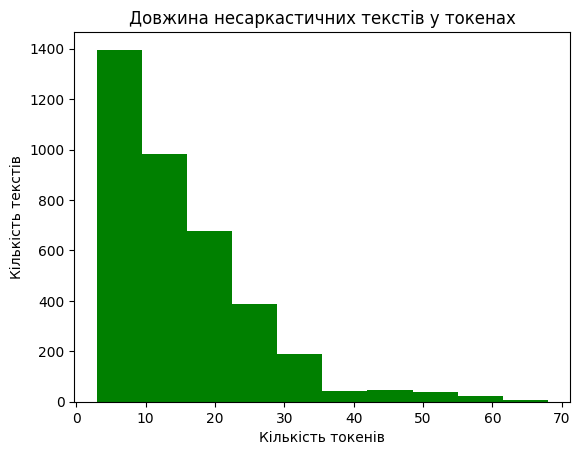

In [ ]:
def plot_tokenized_length(data_column, title):
  tokenizer = TweetTokenizer()
  plt.hist(data_column.apply(lambda x: len(tokenizer.tokenize(x))), color="green")
  plt.title(title)
  plt.xlabel('Кількість токенів')
  plt.ylabel('Кількість текстів')

plot_tokenized_length(data[data['is_sarcastic'] == False]['no_tags'], 'Довжина несаркастичних текстів у токенах')

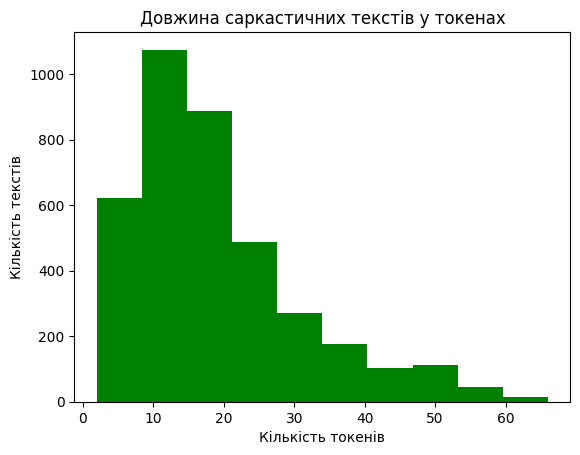

In [ ]:
plot_tokenized_length(data[data['is_sarcastic'] == True]['no_tags'], 'Довжина саркастичних текстів у токенах')

### Calculae top non-stop-words

None


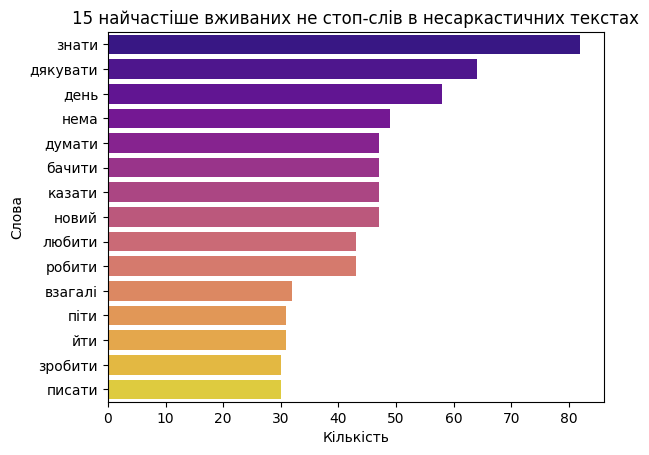

In [ ]:
def plot_top_non_stopwords(data_column, title, n):
  common_words = defaultdict(int)
  for token in TweetTokenizer().tokenize(data_column.to_string()):
    if token not in stops and re.findall("[А-ЩЬЮЯҐЄІЇа-щьюяґєії'`’ʼ-]+", token):
      if token not in common_words:
        common_words[token] = 0
      else:
        common_words[token] += 1
  if common_words['обожнути']:
    common_words['обожнювати'] = common_words['обожнути']
    del common_words['обожнути']
  if common_words['немати']:
    common_words['нема'] = common_words['немати']
    del common_words['немати']
  top = sorted(common_words.items(), key=lambda x:x[1],reverse=True)[:n] 
  stop, count =zip(*top)
  cm_wd = pd.DataFrame({'Слова': stop, 'Кількість': count})
  sns.barplot(data=cm_wd, x='Кількість', y='Слова', palette='plasma').set(title=title)

print(plot_top_non_stopwords(data[data['is_sarcastic'] == False]['lemmatized'],  '15 найчастіше вживаних не стоп-слів в несаркастичних текстах', 15))

None


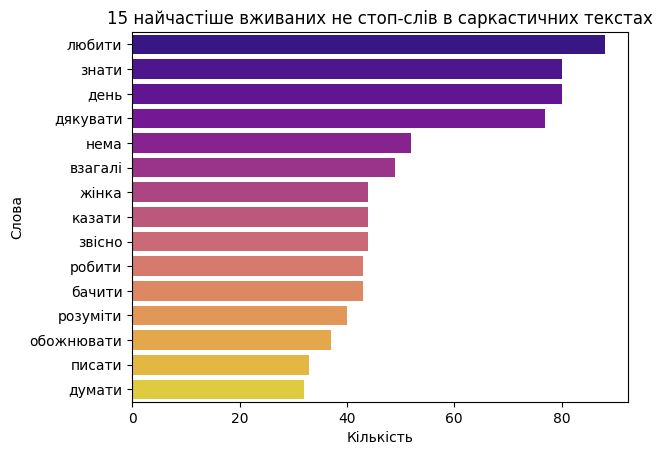

In [ ]:
print(plot_top_non_stopwords(data[data['is_sarcastic'] == True]['lemmatized'], '15 найчастіше вживаних не стоп-слів в саркастичних текстах', 15))

In [ ]:
# data[data['lemmatized'].str.contains('немати') == True]

### Calculate top bigrams

[Text(0.5, 1.0, '15 найчастіше вживаних біграм у несаркастичних текстах'),
 Text(0.5, 0, 'Кількість'),
 Text(0, 0.5, 'Біграми')]

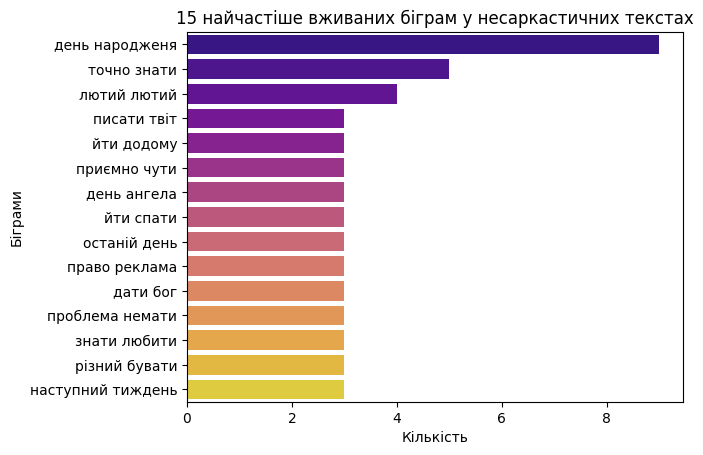

In [ ]:
def get_top_ngram(corpus, k, n=None,):
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stops, token_pattern=r"[А-ЩЬЮЯҐЄІЇа-щьюяґєії'`’ʼ]+").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items() if word != "' '"]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

top_n_bigrams=get_top_ngram(data[data['is_sarcastic'] == False]['lemmatized'],15, 2)
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x, palette='plasma').set(title='15 найчастіше вживаних біграм у несаркастичних текстах', xlabel="Кількість", ylabel="Біграми")

[Text(0.5, 1.0, '15 найчастіше вживаних біграм у саркастичних текстах'),
 Text(0.5, 0, 'Кількість'),
 Text(0, 0.5, 'Біграми')]

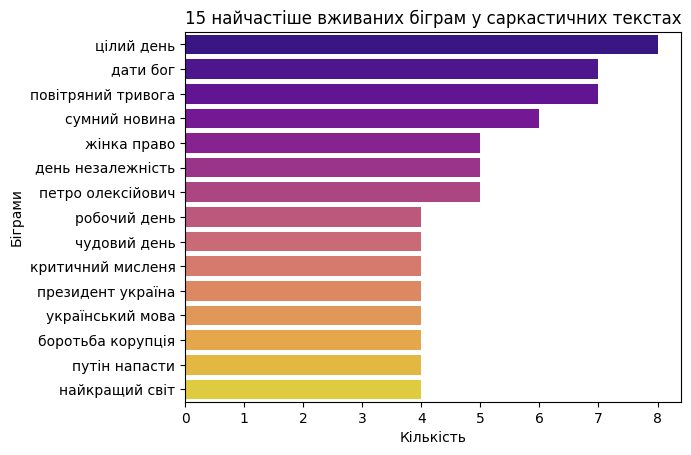

In [ ]:
top_n_bigrams=get_top_ngram(data[data['is_sarcastic'] == True]['lemmatized'],15, 2)
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x, palette='plasma').set(title='15 найчастіше вживаних біграм у саркастичних текстах', xlabel="Кількість", ylabel="Біграми")

# Meta Data Visuzalization

In [ ]:
data['date'] = data['date'].astype(str).apply(lambda x: x.split('-')[0])

dates_s = data[data['is_sarcastic'] == True]['date'].value_counts().to_dict()
dates_n = data[data['is_sarcastic'] == False]['date'].value_counts().to_dict()

print(dates_s['nan'])
del dates_s['nan']

64


In [ ]:
def plot_visuals(data: dict, xlabel:str, ylabel: str, title: str):
  data_keys = list(data.keys())
  data_values = list(data.values())
    
  fig = plt.figure(figsize = (6, 3))

  sns.barplot(x=data_values,y=data_keys, palette='magma').set(title=title, xlabel=xlabel, ylabel=ylabel)
  plt.xticks()

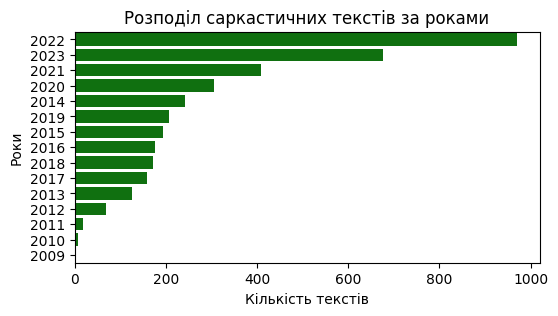

In [ ]:
plot_visuals(dates_s, 'Кількість текстів', 'Роки', 'Розподіл саркастичних текстів за роками')

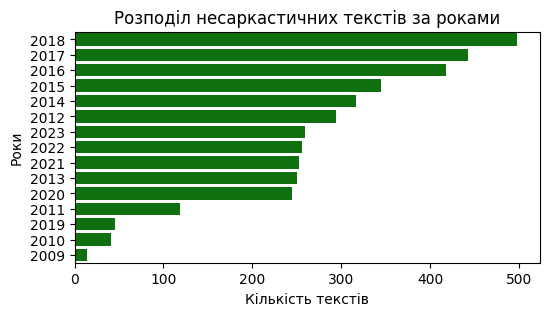

In [ ]:
plot_visuals(dates_n, 'Кількість текстів', 'Роки', 'Розподіл несаркастичних текстів за роками')

In [ ]:
print('Кількість унікальних авторів саркастичних текстів', len(set(data[data['IS_SARCASTIC'] == True]['USERNAME'].to_list())))
print('Кількість унікаьних авторів несаркастичних текстів', len(set(data[data['IS_SARCASTIC'] == False]['USERNAME'].to_list())))

Кількість унікальних авторів саркастичних текстів 2237
Кількість унікаьних авторів несаркастичних текстів 904


# Find emojis and emoticons in text

In [ ]:
def extract_emojis(text: str):
    emoji_dict = adv.extract_emoji([text])
    return emoji_dict['emoji'][0]

def most_common_emojis(emojis: list):
  all_emos = []
  for i in emojis:
    if i:
      all_emos.extend(i)
  return dict(Counter(all_emos).most_common(10))

In [ ]:
emojis_s = data[data['is_sarcastic'] == True]['text'].astype(str).apply(lambda x: extract_emojis(x)).to_list()
emojis_n = data[data['is_sarcastic'] == False]['text'].astype(str).apply(lambda x: extract_emojis(x)).to_list()

In [ ]:
print(most_common_emojis(emojis_s))
print(most_common_emojis(emojis_n))

{'🙄': 131, '🥰': 85, '😍': 70, '🤔': 68, '👍': 59, '😡': 48, '😂': 45, '😱': 40, '😭': 38, '🥺': 31}
{'😭': 18, '😂': 10, '😅': 10, '😍': 10, '💀': 9, '🥺': 7, '💙': 7, '💔': 7, '🤝': 7, '©': 6}


In [ ]:
emot_obj = emot.core.emot()

emoticons_s = Counter(emot_obj.emoticons(data[data['is_sarcastic'] == True]['text'].to_string())['value'])

emoticons_n = Counter(emot_obj.emoticons(data[data['is_sarcastic'] == False]['text'].to_string())['value'])

In [ ]:
print(emoticons_s)
print(emoticons_n)

Counter({':/': 29, ':)': 12, ':3': 3, 'XP': 3, ';)': 2, '=)': 2, '*)': 2, ':-)': 2, ':(': 1, ':)))': 1, ':D': 1, ':))': 1, '=3': 1})
Counter({':)': 63, ':/': 62, ';)': 21, ':(': 14, '=)': 13, ':D': 7, ':3': 6, ':*': 5, ':)))': 3, ':))': 3, ';D': 1, ':-)': 1, 'DX': 1, '8D': 1})


# Find named entities in text

In [ ]:
nlp = spacy.load("uk_core_news_md")

def find_entities(text,n):
  doc = nlp(text)
  return dict(Counter([ent.text for ent in doc.ents]).most_common(n))

ents_s = find_entities(data[data['is_sarcastic'] == True]['lemmatized'].to_string().lower(), 10)
ents_n = find_entities(data[data['is_sarcastic'] == False]['lemmatized'].to_string().lower(), 10)

INFO:pymorphy3.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.10/dist-packages/pymorphy3_dicts_uk/data
INFO:pymorphy3.opencorpora_dict.wrapper:format: 2.4, revision: 1, updated: 2022-09-13T18:45:24.998984


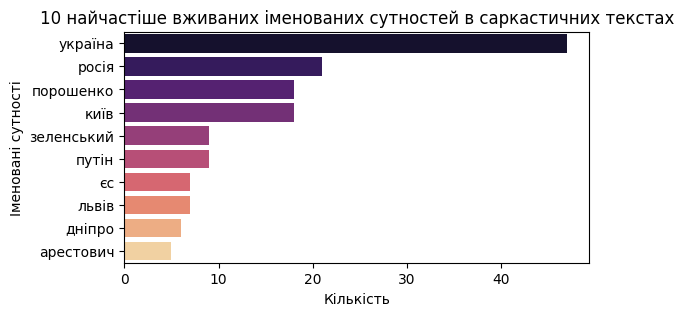

In [ ]:
plot_visuals(ents_s, 'Кількість', 'Іменовані сутності', '10 найчастіше вживаних іменованих сутностей в саркастичних текстах')

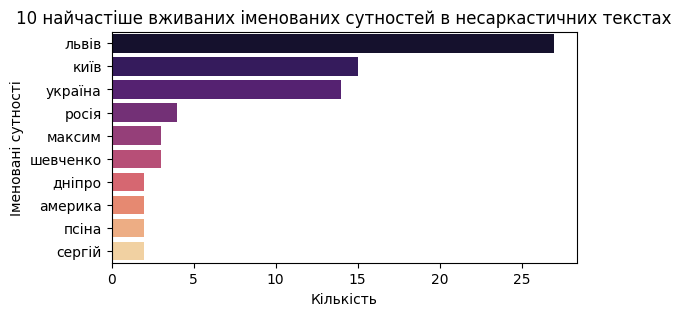

In [ ]:
plot_visuals(ents_n, 'Кількість', 'Іменовані сутності', '10 найчастіше вживаних іменованих сутностей в несаркастичних текстах')